In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [58]:
#Reading training data
filename='../input/train.csv'

train_df=pd.read_csv(filename,nrows=2000000,usecols=[1,2,3,4,5,6,7]) # key column is not required in training.

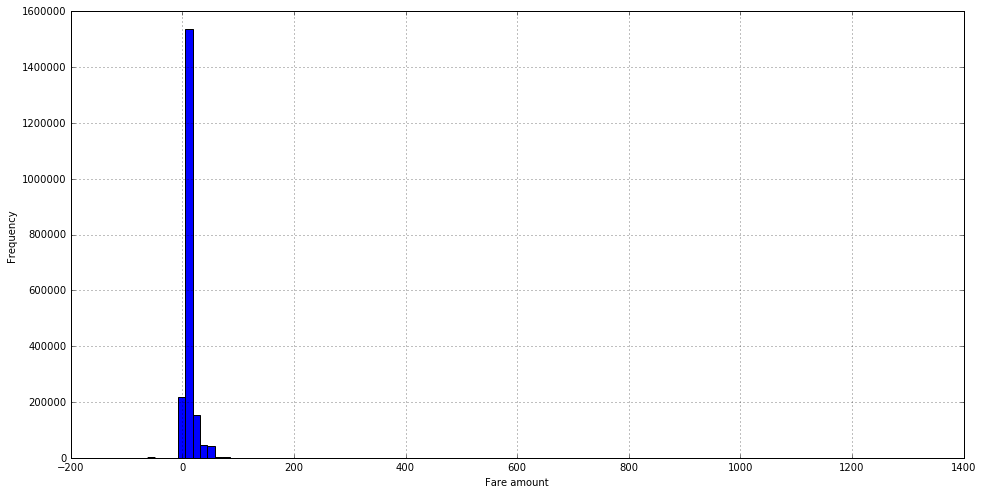

In [3]:

train_df.fare_amount.hist(bins=100,figsize=(16,8))
plt.xlabel("Fare amount")
plt.ylabel("Frequency")


In [4]:
train_df['fare_amount'].quantile([0.001,0.999])

0.001     2.5
0.999    80.0
Name: fare_amount, dtype: float64

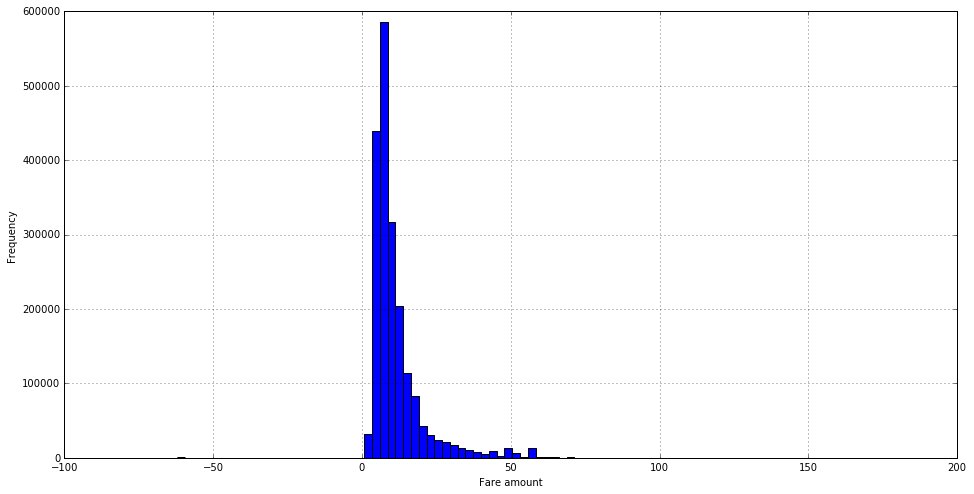

In [5]:
train_df[train_df.fare_amount<200].fare_amount.hist(bins=100,figsize=(16,8))
plt.xlabel("Fare amount")
plt.ylabel("Frequency")


In [6]:
#Removing rows with null values and zero values

print('Old size:%d '%len(train_df))
train_df=train_df.dropna(how='any',axis='rows')
train_df = train_df[(train_df != 0).any(axis=1)]
print('New size:%d '%len(train_df))

Old size:2000000 
New size:1999986 


In [34]:
print('Old size:%d '%len(train_df))
#Removing rows whose coordinates not between new york boundary: https://www.travelmath.com/cities/New+York,+NY
# as well as with more than 6 passangers and whose fare_amount is more than 200.
mask = train_df['dropoff_latitude'].between(40,42)
mask &= train_df['pickup_latitude'].between(40,42)
mask &= train_df['pickup_longitude'].between(-75,-71)
mask &= train_df['dropoff_longitude'].between(-75,-71)
mask &= train_df['fare_amount'].between(2.5,200)
mask &= train_df['passenger_count'].between(0,8)

train_df=train_df[mask]
print('New size:%d '%len(train_df))

Old size:1958133 
New size:1958133 


In [8]:
#Reading test data
test_filename='../input/test.csv'


test_df=pd.read_csv(test_filename)
test_df.describe()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [9]:
#Rounding coordinates to 2 decimal places so near places can be identified easily.
def round_coord(data):
    data['pickup_longitude']=round(data['pickup_longitude'],2)
    data['pickup_latitude']=round(data['pickup_latitude'],2)
    data['dropoff_latitude']=round(data['dropoff_latitude'],2)
    data['dropoff_longitude']=round(data['dropoff_longitude'],2)
    return data

In [10]:
#Rouding latitude and longitude to 2 floating value

train_df=round_coord(train_df)

test_df=round_coord(test_df)
print(train_df.shape)
print(test_df.shape)

(1958133, 7)
(9914, 7)


In [11]:
#Finding euclidean distance between 4 points
def euclidean_distance(latitude_distance,longitude_distance):
    return np.sqrt(latitude_distance**2+longitude_distance**2)
    

In [12]:
def absolute_distance(data):
    data['latitude_distance']=abs(data['dropoff_latitude']-data['pickup_latitude'])
    data['longitude_distance']=abs(data['dropoff_longitude']-data['pickup_longitude'])
    return data

In [13]:
#Finding euclidean as well as absolute distance between coordinates for both training and test data set
train_df=absolute_distance(train_df)

test_df=absolute_distance(test_df)

train_df['euclidean']=euclidean_distance(train_df['latitude_distance'],train_df['longitude_distance'])

test_df['euclidean']=euclidean_distance(test_df['latitude_distance'],test_df['longitude_distance'])

print(train_df.shape)
print(test_df.shape)

(1958133, 10)
(9914, 10)


In [14]:

#Convert pickup datetime to datetime and extract the different parts and add them in dataset.
def convert_extract_datetime(df):
    time=df['pickup_datetime'].astype(str).str[:-4]
    df['date_time']=pd.to_datetime(time,format='%Y%m%d %H:%M:%S')
    df['hour']=df['date_time'].dt.hour
    df['day']=df['date_time'].dt.day
    df['month']=df['date_time'].dt.month
    df['year']=df['date_time'].dt.year
    df['weekday']=df['date_time'].dt.weekday
    df=df.drop(['date_time','pickup_datetime'],axis=1)
    return df

In [15]:
#Convert pickup time for both training and test data

train_df=convert_extract_datetime(train_df)

test_df=convert_extract_datetime(test_df)

print(train_df.shape)
print(test_df.shape)

(1958133, 14)
(9914, 14)


In [16]:
#Find distance between coordinates using haversine formula
def dist_coord(pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude):
    R=6371e3
    pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude=map(np.radians,[pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude])
    dlon=dropoff_longitude-pickup_longitude
    dlat=dropoff_latitude-pickup_latitude
    a=np.sin(dlat/2.0)**2 + np.cos(pickup_latitude)*np.cos(dropoff_latitude)+np.sin(dlon/2.0)**2
    c=2*np.arcsin(np.sqrt(a))
    distance=R * c
    return distance

In [17]:
#Find spherical distance between coordinates as well as their distance from airports.
def calculate_distances(data):
    
    # airport
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)
    
        
    pickup_jfk=dist_coord(jfk[1],data['pickup_latitude'],jfk[0],data['pickup_longitude'])
    dropoff_jfk=dist_coord(jfk[1],data['dropoff_latitude'],jfk[0],data['dropoff_longitude'])
    
    pickup_ewr=dist_coord(ewr[1],data['pickup_latitude'],ewr[0],data['pickup_longitude'])
    dropoff_ewr=dist_coord(ewr[1],data['dropoff_latitude'],ewr[0],data['dropoff_longitude'])
    
    pickup_lgr=dist_coord(lgr[1],data['pickup_latitude'],lgr[0],data['pickup_longitude'])
    dropoff_lgr=dist_coord(lgr[1],data['dropoff_latitude'],lgr[0],data['dropoff_longitude'])
    
    data['jfk_distance']=pd.concat([pickup_jfk,dropoff_jfk],axis=1).min(axis=1)
    data['ewr_distance']=pd.concat([pickup_ewr,dropoff_ewr],axis=1).min(axis=1)
    data['lgr_distance']=pd.concat([pickup_lgr,dropoff_lgr],axis=1).min(axis=1)
    
    data['distance']=dist_coord(data['pickup_latitude'],data['dropoff_latitude'],data['pickup_longitude'],data['dropoff_longitude'])
    return data

In [18]:
#calculate distance for both training and test data set

train_df=calculate_distances(train_df)

test_df=calculate_distances(test_df)

In [19]:
def pearson_corr(data):
    print('Pearson correlation between Euclidean distance and taxi fare:{}'.format(data['euclidean'].corr(data['fare_amount'])))
    print('Pearson correlation between time of day and distance travelled:{}'.format(data['hour'].corr(data['distance'])))
    print('Pearson correlation between time of day and taxi fare:{}'.format(data['hour'].corr(data['fare_amount'])))

Pearson correlation between Euclidean distance and taxi fare:0.8217240644648116
Pearson correlation between time of day and distance travelled:-0.024754780263319745
Pearson correlation between time of day and taxi fare:-0.018151198068974545


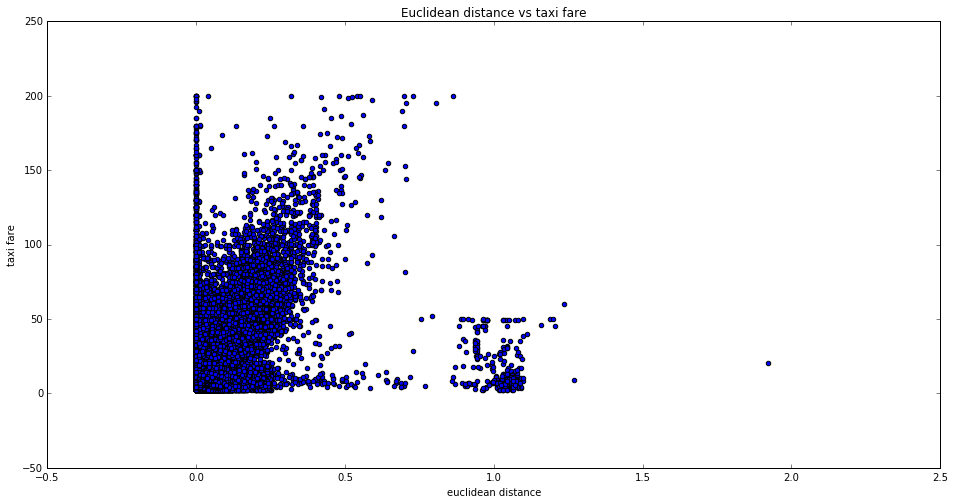

In [20]:
pearson_corr(train_df)


plt.figure(figsize=(16,8))
plt.xlabel('euclidean distance')
plt.ylabel('taxi fare')
plt.title('Euclidean distance vs taxi fare')
plt.scatter(train_df['euclidean'],train_df['fare_amount'])
plt.savefig('plot1.jpg')

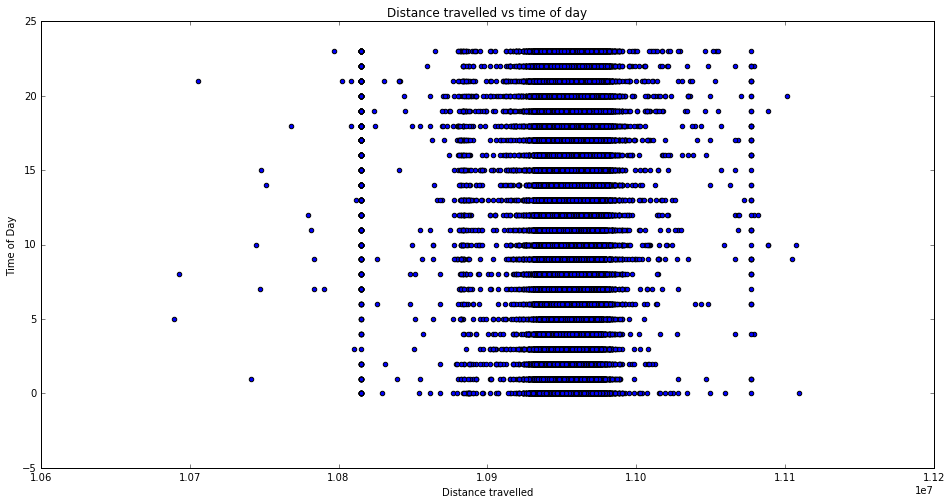

In [21]:
plt.figure(figsize=(16,8))
plt.title('Distance travelled vs time of day')
plt.xlabel('Distance travelled')
plt.ylabel('Time of Day')
plt.scatter(train_df['distance'],train_df['hour'])
plt.savefig('plot2.jpg')

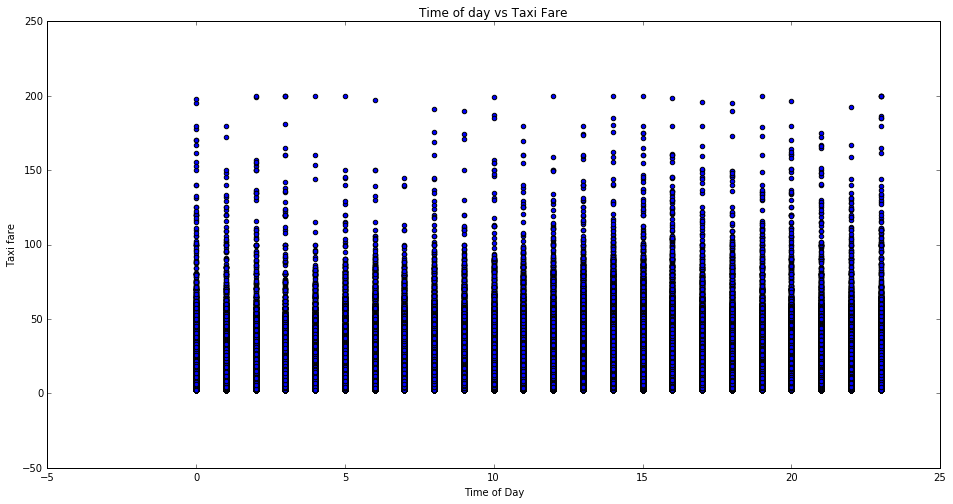

In [22]:
plt.figure(figsize=(16,8))
plt.title('Time of day vs Taxi Fare')
plt.xlabel('Time of Day')
plt.ylabel('Taxi fare')
plt.scatter(train_df['hour'],train_df['fare_amount'])
plt.savefig('plot3.jpg')

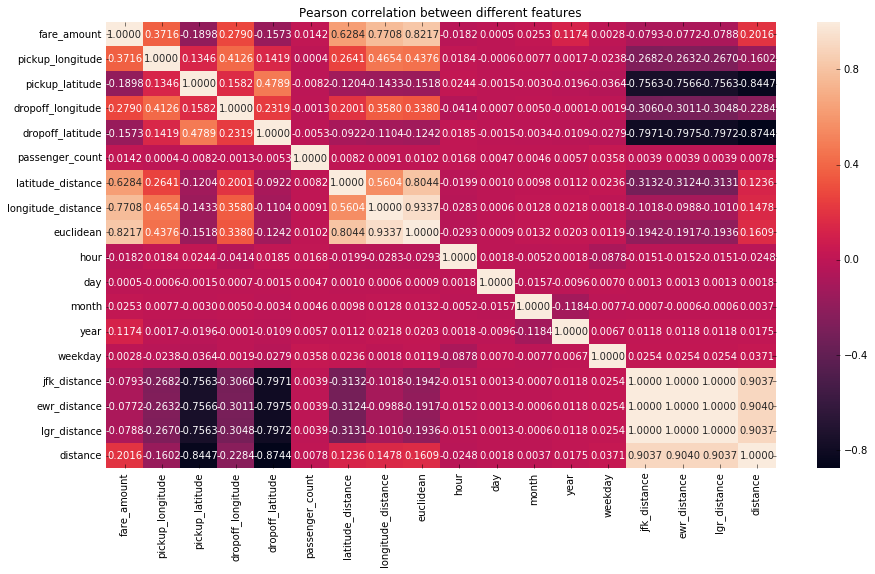

In [23]:

plt.figure(figsize=(15,8))
plt.title('Pearson correlation between different features')
svm=sns.heatmap(train_df.corr(),annot=True,fmt='.4f')
fig=svm.get_figure()
fig.savefig('pearson_coefficient.jpg')

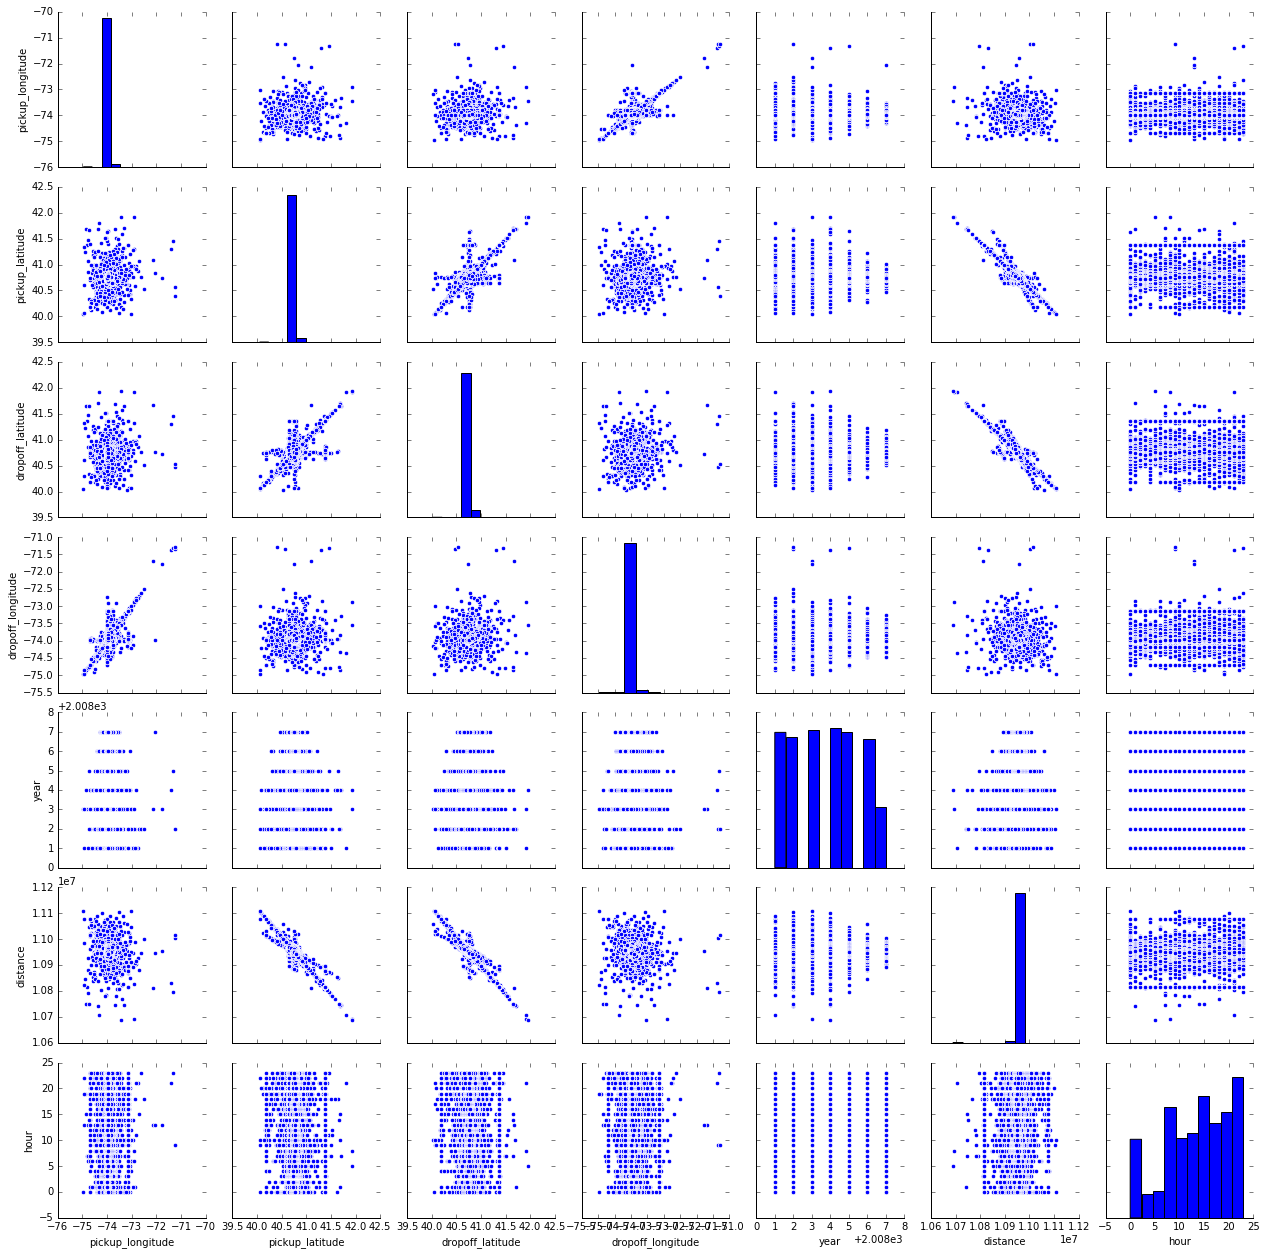

In [24]:
feature_cols=['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','year','distance','hour']
sns_plot=sns.pairplot(train_df[feature_cols])
sns_plot.savefig("plot4.jpg")

In [54]:
#Base model using linear regression
feature_cols=['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','year','distance','hour']

y=train_df['fare_amount']
X=train_df[feature_cols]



In [55]:


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)
model=LinearRegression()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("Root mean squred error(Base Model):{}".format(rmse))

print("Base Coefficients:")
print(model.coef_)


Root mean squred error(Base Model):7.812388690045778
Base Coefficients:
[  5.59943732e+01   2.73494220e+04   2.73738432e+04   4.51545815e+01
   5.74106667e-01   2.46505107e-01  -7.89237663e-03]


In [27]:
X_t=test_df[feature_cols]
test_pred=model.predict(X_t)
test_pred=np.round(test_pred,decimals=2)

submission=pd.DataFrame({'key':test_df.key,'fare_amount':test_pred},columns=['key','fare_amount'])
submission.to_csv('base.csv',index=False)


In [28]:
#Linear regression with added features
y=train_df['fare_amount']
X=train_df.drop('fare_amount',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)
model=LinearRegression()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("Root mean squred error(Linear Regression with added features):{}".format(rmse))




Root mean squred error(Linear Regression with added features):4.785793838661604


In [29]:
X_t=test_df.drop('key',axis=1)
test_pred=model.predict(X_t)
test_pred=np.round(test_pred,decimals=2)

submission=pd.DataFrame({'key':test_df.key,'fare_amount':test_pred},columns=['key','fare_amount'])
submission.to_csv('linear.csv',index=False)

In [30]:

rfr=RandomForestRegressor(n_estimators=100,max_depth=7)

rfr.fit(X_train,y_train)

y_pred=rfr.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("Root mean squred error(Random Forest Regressor):{}".format(rmse))

Root mean squred error(Random Forest Regressor):4.169636085919741


In [31]:
test_pred=rfr.predict(X_t)
test_pred=np.round(test_pred,decimals=2)

submission=pd.DataFrame({'key':test_df.key,'fare_amount':test_pred},columns=['key','fare_amount'])
submission.to_csv('random_forest.csv',index=False)


In [32]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

xg_reg=xgb.XGBRegressor(objective='reg:linear',n_estimators=300,colsample_bytree=0.5,max_depth=8)
xg_reg.fit(X_train,y_train)

y_pred=xg_reg.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("Root mean squred error(Extreme Gradient Boost):{}".format(rmse))

Root mean squred error(Extreme Gradient Boost):3.7417310405174167


In [33]:
test_pred=xg_reg.predict(X_t)
test_pred=np.round(test_pred,decimals=2)

submission=pd.DataFrame({'key':test_df.key,'fare_amount':test_pred},columns=['key','fare_amount'])
submission.to_csv('xgboost.csv',index=False)
